In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

# Comparing MAG/SAG quality

## Overview

Here various statistics of the binned MAGs and the sequenced SAGs are presented.

Some definitions:
- **contamination**: This is estimated by the number of multi-copy marker genes found in each bin, expressed as % (total markers = 56).
- **completeness**: This is estimated by the number of marker genes found, expressed as % (total markers = 56).
- **ContigLength**: This is the minimum contig length used for binning the assemblies. All contigs shorter than this are discarded prior to binning. The MAGs have been binned using 500 bp, 1000 bp (MaxBin2 default) and 2000 bp length cutoffs.

## Functions

In [2]:
def add_contig_length(df):
    min_contig_lengths = []
    for index in df.index:
        l = index.split(".")[-1]
        if "k" in l:
            min_contig_lengths.append("{}000".format(l[0]))
        else:
            min_contig_lengths.append("500")
    return df.assign(ContigLength=pd.Series(min_contig_lengths, index=df.index))

In [3]:
def add_assembly_col(g, a):
    assembly=[]
    for genome in g.index:
        try:
            a.loc[genome.split(".")[0]]
            assembly.append(genome.split(".")[0])
        except KeyError:
            assembly.append("NONE")
    return g.assign(Assembly=pd.Series(assembly,index=g.index))

In [4]:
def filter_to_single_sample_assemblies(df):
    single_sample_assemblies = ["KR11_Ju","KR11_N2","KR11_N3","KR11_S3","KR13_Ju","KR13_N1","KR13_N2","KR13_S3","KR46_Ju","MML_A","MML_B","MMS_A","MMS_B","Modern_marine_glass_biofilm","Modern_marine_rock_biofilm","Old_saline_glass_biofilm","Old_saline_rock_biofilm","OSL_A","OSL_B","OSS_A","OSS_B","UML_A","UML_B","UMS_A","UMS_B"]
    mags = []
    for a in single_sample_assemblies:
        r = df.loc[df.index.str.contains(a)]
        mags+=list(r.index)
    return df.loc[mags]

In [5]:
def add_taxonomy_columns(df):
    taxdict = {"kingdom": [], "phylum": [], "class": [], "order": [], "family": [], "genus": [], "species": []}
    rank_letters = {"k": "kingdom", "p": "phylum", "c": "class", "o": "order", "f": "family", "g": "genus", "s": "species"}
    ranks = ["kingdom","phylum","class","order","family","genus","species"]
    for i, t in enumerate(df.Taxonomy):
        try: 
            results = t.split(";")
        except AttributeError:
            for rank in ranks:
                taxdict[rank].append("Unclassified")
            continue
        for j, a in enumerate(results):
            rank = a.split("_")[0]
            name = a.replace("{}__".format(rank),"").replace(" (root)","").replace("_"," ")
            taxdict[rank_letters[rank]].append(name)
        for rank in ranks[j+1:]:
            taxdict[rank].append("Unclassified.{}".format(name))

    return pd.merge(df,pd.DataFrame(taxdict,index=df.index)[ranks], left_index=True, right_index=True)

In [6]:
def add_qual_col(df, min_comp, max_cont):
    df = df.assign(Quality=pd.Series(["Bad"], index=df.index))
    if len(df.loc[(df.Completeness>=min_comp)&(df.Contamination<=max_cont)]) > 0:
        df.loc[(df.Completeness>=min_comp)&(df.Contamination<=max_cont),"Quality"] = "Good"
    return df

In [7]:
def count_genomes(mag_stats, sag_stats, min_comp=80, max_cont=5):
    # Filter dataframes
    sag_df = sag_stats.loc[(sag_stats.Completeness>=min_comp)&(sag_stats.Contamination<=max_cont)]
    mag_df = mag_stats.loc[(mag_stats.Completeness>=min_comp)&(mag_stats.Contamination<=max_cont)]
    # For SAGs, just count per phylum
    sag_counts = sag_df.groupby(["phylum"]).count().reset_index()[["phylum","# genomes"]]
    sag_counts.set_index("phylum", inplace=True)
    sag_counts.columns = ["# genomes"]
    sag_counts = sag_counts.assign(ContigLength=pd.Series(["SAGs"], index=sag_counts.index))
    sag_counts = sag_counts.assign(Contamination=pd.Series([max_cont], index=sag_counts.index))
    sag_counts = sag_counts.assign(Completeness=pd.Series([min_comp], index=sag_counts.index))
    sag_counts = sag_counts.assign(Assembly=pd.Series(["SAGs"], index=sag_counts.index))
    # For MAGs count genomes per phylum, contig length and assembly
    mag_counts = mag_df.groupby(["Assembly","ContigLength","phylum"]).count().reset_index()[["Assembly","ContigLength","phylum","# genomes"]]
    mag_counts = mag_counts.assign(Contamination=pd.Series([max_cont], index=mag_counts.index))
    mag_counts = mag_counts.assign(Completeness=pd.Series([min_comp], index=mag_counts.index))
    counts = pd.concat([mag_counts,sag_counts])
    counts.fillna(0, inplace=True)
    return counts

In [8]:
def calculate_percent_bp(df, comp, cont, qual):
    _df = df.groupby(["Assembly","ContigLength"]).sum().reset_index()[["Assembly","ContigLength","Genome size (bp)"]]
    _df = pd.merge(_df,pd.DataFrame(assembly_stats.loc[:,"total_size_bp"]), left_on="Assembly",right_index=True)
    _df = _df.assign(percent_bp=pd.Series(_df["Genome size (bp)"] / _df["total_size_bp"] * 100))
    _df = _df.assign(Quality=pd.Series([qual]*len(_df)))
    _df = _df.assign(MinComp=pd.Series([comp]*len(_df)))
    _df = _df.assign(MaxCont=pd.Series([cont]*len(_df)))
    _df = _df.assign(Bins=df.groupby(["Assembly","ContigLength"]).count().reset_index()["# genomes"])
    return _df

In [9]:
def fix_axes(ax):
    for row_ax in ax.axes:
        for axis in row_ax:
            ymin,ymax = axis.get_ylim()
            ymin = 0
            if ymax<5:
                ymax = 5
            axis.set_ylim(ymin,ymax)
            a = axis.get_title().split(" ")[0]
            n50_l = assembly_stats.loc[a,"N50_length"]
            axis.set_title(axis.get_title().replace(a,"{} ({}bp)".format(a,int(n50_l))))    

## Reading the data

Specify thresholds for filtering weird MAGs

In [10]:
max_genome_size = 20000000
min_genome_size = 100000

Specify default thresholds for 'good quality'

In [11]:
min_completeness = 80
max_contamination = 5

Read stats files on genomes and assemblies

In [12]:
assembly_stats = pd.read_table("data/assembly_stats.txt", index_col=0)
sorted_assemblies = list(assembly_stats.sort_values("total_size_bp").index)
sorted_assemblies.remove("all")
single_sample_assemblies = ["KR11_Ju","KR11_N2","KR11_N3","KR11_S3","KR13_Ju","KR13_N1","KR13_N2","KR13_S3","KR46_Ju","MML_A","MML_B","MMS_A","MMS_B","Modern_marine_glass_biofilm","Modern_marine_rock_biofilm","Old_saline_glass_biofilm","Old_saline_rock_biofilm","OSL_A","OSL_B","OSS_A","OSS_B","UML_A","UML_B","UMS_A","UMS_B"]

In [34]:
genome_stats = pd.read_table("data/genome_stats.tab", index_col=0)
prefilter = len(genome_stats)
# Filter genomes
genome_stats = genome_stats.loc[(genome_stats["Genome size (bp)"]<= max_genome_size)&(genome_stats["Genome size (bp)"]>=min_genome_size)]
postfilter = len(genome_stats)
# Add taxonomy columns
genome_stats = add_taxonomy_columns(genome_stats)
# Filter out MAG genomes only (those containing "." in genome_id)
sag_stats = genome_stats.loc[~genome_stats.index.str.contains("\.")]
mag_stats = genome_stats.loc[genome_stats.index.str.contains("\.")]
# Add column specifying minimum contig length
mag_stats = add_contig_length(mag_stats)
# Add assembly column to genome stats
mag_stats = add_assembly_col(mag_stats, assembly_stats)
print("{} genomes filtered by length".format(prefilter-postfilter))

0 genomes filtered by length


Add column specifying if genome is of good quality.

In [14]:
mag_stats = add_qual_col(mag_stats, min_completeness, max_contamination)
sag_stats = add_qual_col(sag_stats, min_completeness, max_contamination)

In [15]:
phyla = sorted(list(mag_stats.phylum.unique())+list(sag_stats.phylum.unique()))
sag_phyla = set(sorted(list(sag_stats.phylum.unique())))
mag_phyla = set(sorted(list(mag_stats.phylum.unique())))
phyl_cols = dict(zip(phyla, sns.color_palette("Set1",10)+sns.color_palette("Set2",10)+sns.color_palette("husl", 8)+sns.color_palette("Dark2", 7)))

## Plots

### Completeness/contamination per taxonomy

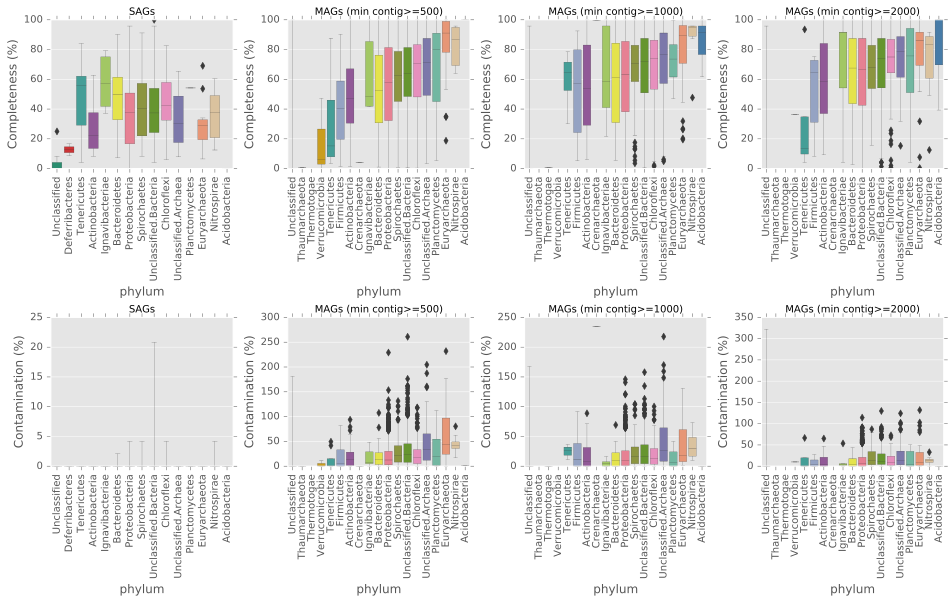

In [16]:
# Sort phyla by completeness (MAGs)
sorted_phyla = pd.concat([mag_stats.groupby("phylum").median(),sag_stats.groupby("phylum").median().loc[sag_phyla.difference(mag_phyla)]]).sort_values("Completeness").index
sorted_sag_phyla = [x for x in sorted_phyla if x in list(sag_stats.phylum.unique())]
sorted_mag_phyla = [x for x in sorted_phyla if x in list(mag_stats.phylum.unique())]
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16,8))
sorted_sag_phyla = [x for x in sorted_phyla if x in list(sag_stats.phylum.unique())]

sorted_mag_phyla = [x for x in sorted_phyla if x in list(mag_stats.phylum.unique())]
values = ["Completeness","Contamination"]
for j, row_ax in enumerate(axes):
    ax1 = sns.boxplot(data=sag_stats, x="phylum", y=values[j], palette=phyl_cols, ax=row_ax[0], order=sorted_sag_phyla, linewidth=0.2)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90);
    ax1.set_ylabel("{} (%)".format(values[j]))
    ax1.set_title("SAGs", fontsize=10)
    for i, l in enumerate(["500","1000","2000"], start=1):
        ax2 = sns.boxplot(data=mag_stats.loc[mag_stats.ContigLength==l], x="phylum", y=values[j], palette=phyl_cols, ax=row_ax[i], order=sorted_mag_phyla, linewidth=0.2)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90);
        ax2.set_ylabel("{} (%)".format(values[j]))
        ax2.set_title("MAGs (min contig>={})".format(l), fontsize=10);
plt.subplots_adjust(wspace=0.3, hspace=1)
plt.savefig("figures/pdf/stats_per_phyla.pdf", bbox_inches="tight", dpi=300)
plt.savefig("figures/png/stats_per_phyla.png", bbox_inches="tight", dpi=300)

#### Summary

The level of completeness is generally higher in the MAGs. Also, the only phylum not picked up in the MAGs is Deferribacteres. While the SAGs have very little contamination overall, with a few outliers, the MAGs have a lot of genomes with high contamination. In general, the contamination decreases for longer contig lengths in all phyla.

The reason that the completeness level increases in the 1000 bp minimum contig length but decreases in the 2000 bp length could be that in the 500 bp length there is too much noise which breaks bins apart while in the 2000 length there is not enough coverage of the genomes.

### Number of 'good quality' genomes

Count the number of genomes at varying levels of contamination (0%, 2.5%, 5%) and completeness (50%, 60%, 70%, 75%, 80%, 85%, 90%, 95%, 100%).

In [17]:
genome_counts = pd.DataFrame()
for comp in [50,60,75,80,85,90,95,100]:
    for cont in [0,2.5,5]:
        genome_counts = pd.concat([genome_counts,count_genomes(mag_stats, sag_stats, min_comp=comp, max_cont=cont)])

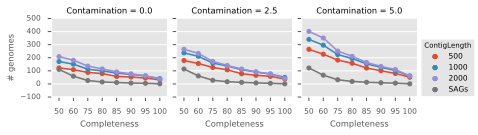

In [18]:
_df = genome_counts.groupby(["ContigLength","Completeness","Contamination"]).sum().reset_index()
with sns.plotting_context("notebook", font_scale=0.75):
    sns.factorplot(data=_df, x="Completeness", y="# genomes", estimator=sum, hue="ContigLength", col="Contamination",
                  size=2, scale=0.5, hue_order=["500","1000","2000","SAGs"])
    plt.savefig("figures/pdf/total_genomes.pdf", dpi=300, bbox_inches="tight")
    plt.savefig("figures/png/total_genomes.png", dpi=300, bbox_inches="tight")

#### Summary

The number of genomes obtained is lower for the 500 bp cutoff at all considered levels of completeness and contamination. The 1000 and 2000 bp cutoffs give comparable number of genomes.

### Total number of genomes per assembly

One assembly per row, one contamination level per column. Subplots have assembly name in title + N50_length in parenthesis. Rows (assemblies) are sorted by total assembly size.

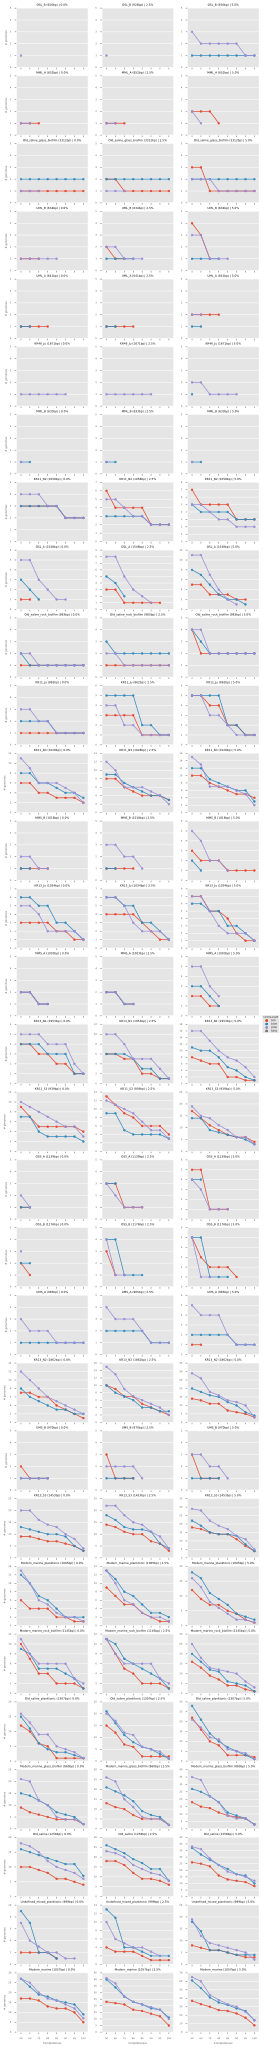

In [19]:
_df = genome_counts.loc[genome_counts.Assembly!="SAGs"].groupby(["ContigLength","Completeness","Contamination","Assembly"]).sum().reset_index()
with sns.plotting_context("notebook", font_scale=0.5):
    ax = sns.factorplot(data=_df, x="Completeness", y="# genomes", estimator=sum, hue="ContigLength", col="Contamination",
                  size=2, aspect=1.3, scale=0.5, row_order=sorted_assemblies, hue_order=["500","1000","2000","SAGs"], row="Assembly", sharey=False)
    ax.set_titles("{row_name} | {col_name}%")    
    # Fix axes and adjust titles to contain N50_length
    fix_axes(ax)
    # Adjust subplots
    plt.subplots_adjust(wspace=0.2)
    # Save figure
    plt.savefig("figures/png/genomes_per_assembly.png", dpi=300, bbox_inches="tight")
    plt.savefig("figures/pdf/genomes_per_assembly.pdf", dpi=300, bbox_inches="tight")

#### Summary

Several assemblies do not generate any MAGs at all at for some combinations of contamination/completeness/contig length cutoff. However, for most assemblies the 1000 bp or 2000 bp cutoffs generate the highest number of genomes at all completeness levels.

### Percent of assemblies binned

Here the total % of basepairs binned into MAGs in each assembly is plotted at varying contig length cutoffs, contamination and completeness.

In [20]:
qual_df = pd.DataFrame()
for comp in [50, 60, 70, 75, 80, 85, 90, 95, 100]:
    for cont in [0,2.5,5]:
        good_qual = mag_stats.loc[(mag_stats.Completeness>=comp)&(mag_stats.Contamination<=cont)]
        bad_qual = mag_stats.loc[(mag_stats.Completeness<comp)|(mag_stats.Contamination>cont)]
        qual_df = pd.concat([qual_df,calculate_percent_bp(good_qual, comp, cont, "Good")])
        qual_df = pd.concat([qual_df,calculate_percent_bp(bad_qual, comp, cont, "Bad")])    

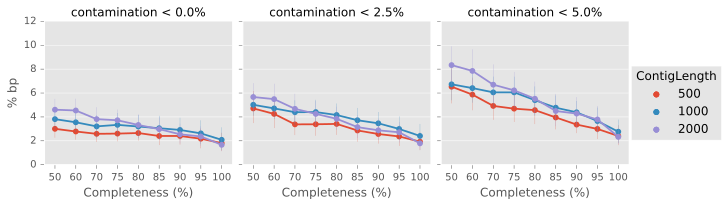

In [21]:
ax = sns.factorplot(data=qual_df.loc[qual_df.Quality=="Good"], hue_order=["500","1000","2000"], x="MinComp", hue="ContigLength", col="MaxCont", y="percent_bp", scale=1, errwidth=0.2, size=3)
ax.set_titles("contamination < {col_name}%", fontsize=8)
for axis in ax.axes:
    for a in axis:
        a.set_xlabel("Completeness (%)")
ax.set_ylabels("% bp")
plt.savefig("figures/pdf/percent_binned.pdf", bbox_inches="tight", dpi=300)
plt.savefig("figures/png/percent_binned.png", bbox_inches="tight", dpi=300)

#### Summary

Total %binned basepairs is comparable for the 1000 and 2000 bp cutoffs. At the 100% completeness level, the %binned bp converge for the three cutoffs.

In [30]:
len(mag_stats.loc[mag_stats.ContigLength=="1000"])

2153